In [1]:
import os
import sys

# Add project root to path to allow importing from model
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from model.utils.validation_utils import test_prop_partial_discretization_matches_ode

# To make plots appear in the notebook
%matplotlib inline

## Model Validations

The purpose of this notebook to validate the outputs generated by our discretized Lotka-Volterra(LV) system against what would be expected from a standard Python Ordinary Differential Equations (ODE) solver. 

The standard LV system is described as:

$$
\begin{align}
\frac{ds}{dt} &= \alpha x - \beta xy \\
\frac{dw}{dt} &= -\gamma y + \delta xy
\end{align}
$$

where (adapted from [Wikipedia's Lotka-Volterra equations page](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)):[^1]

- The variable $x$ is the population of prey (for example, the number of rabbits per square kilometre)
- The variable $y$ is the population of some predator (for example, the number of foxes per square kilometre)  
- $\frac{dy}{dt}$ and $\frac{dx}{dt}$ represent the instantaneous growth rates of the two populations
- $t$ represents time
- The prey's parameters, $\alpha$ and $\beta$, describe, respectively, the maximum prey per capita growth rate, and the effect of the presence of predators on the prey death rate
- The predator's parameters, $\gamma$ and $\delta$, respectively describe the predator's per capita death rate, and the effect of the presence of prey on the predator's growth rate
- All parameters are positive and real

### Introduction

Our implementation of Lotka-Volterra employs wolves (predators) and sheep (prey) as model organisms. So:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \beta sw \\
\frac{dw}{dt} &= -\gamma w + \delta sw
\end{align}
$$

where $w$ is number of wolves and $s$ number of sheep.

In our "partially discretized" model implementation of the LV system, the continuous curve of the predator population, wolves, is replaced by the use of a model implementation in which wolf "agents" are individualized and have discrete, integer population counts at every step. The discrete population notably cannot rebound from a sub-1 value.  The prey population, the sheep, are left to operate as a single population group, with non-discrete (implemented as a floating point number, so our discretion is limited!) populations that can exist at sub-1 counts.

Our "fully discretized" model implementation also transitions the prey population to discrete integer counts.

The implementation of discretized systems is widely discussed and debated in simulation and agent-based modeling literature. Our approach is based on a Euler-stepped approach described in the accompanying notebook, `introducing_do_android_wolves.ipynb`. In this notebook we will evaluate the similarities and differences between our novel approach and the values that a solver can generate using the same LV system of equations.

## Data assembly

We will be performing several runs through the LV system in this notebook, and some parameters will vary from run to run. Generally speaking for the project we are not so interested in the outcome permutations generated by the traditional LV variables, as the effects of different settings of these parameters is well-settled science. However, we might be interested to confirm whether or not our system diverges from the main system, so we will investigate this in a bit.

To get started, we will use the parameters we employ throughout the study:
```
        "alpha": 1,
        "beta": 0.1,
        "gamma": 1.5,
        "delta": 0.75,
```

This means that our system equations will evaluate as:

```
        ds_dt = 1 * s - 0.1 * s * w
        dw_dt = -1.5 * w + 0.75 * s * w
```

... where `w` and `s` are our sheep and wolves counts. Let's take a look at the solver working with these equations, 


and we will watch the ODE solver compute an output using these numbers.

## A note on time and solvers

One theoretical difference between our discretized model and the continous functions they are intended to instantiate is the modeling application of finite time. Effectively, in order for our model to be a model, our model agents need discrete time points at which they can observe and interact with the environment. Meanwhile, since we are attempting to orchestrate domain processes that operate according to the continous system, our discrete time points also need enough organization so that we can reassemble their history in a way that they can be compared against a similar amount of continuous time. We accomplish this, in the case of this and many other models, using "steps," which are points in time spaced equally using a variable we call `dt`. This variable name is of course not an accident; our `dt` is designed to match up with the same "delta time (dt)" variable governing the continuous system.

As a result of our use of discrete time points, it is expected that our simulation will operate in a more "coarse" fashion than the underlying continuous system. However, another concept to note here is that we will use a "continuous equation solver" (`scipy-integrate.solve-ivp`)implemented for Python to represent the output of the continuous equations. That program, being a computer program running in our universe, also uses discrete steps, although by default they are far finer than the ones that we use in our model. Nonetheless, it should be acknowledged that we are working with discrete computing with both systems, and that we might expect for the output solutions to conform more closely as the gap between time-step scales of the two systems is reduced (for instance, as `dt` is set smaller in our discretized version.)

Wolves went extinct at step 543
{'steps': 1000, 'sheep_history': [5, 5.05, 5.1005, 5.151505, 5.20302005, 5.2550502505, 5.297090652504, 5.3394673777240325, 5.382183116745825, 5.4144762154462995, 5.446963072738978, 5.4796448511754114, 5.501563430580113, 5.523569684302434, 5.545663963039643, 5.5567552909657225, 5.567868801547654, 5.567868801547654, 5.567868801547654, 5.5567330639445585, 5.53450613168878, 5.512368107162025, 5.479293898519053, 5.446418135127939, 5.402846790046915, 5.348818322146446, 5.284632502280688, 5.22121691225332, 5.148119875481774, 5.065749957474065, 4.974566458239532, 4.875075129074741, 4.767823476235097, 4.653395712805454, 4.541714215698123, 4.423629646089972, 4.299768015999453, 4.170774975519469, 4.037310176302846, 3.900041630308549, 3.759640131617441, 3.624293086879213, 3.486569949577803, 3.347107151594691, 3.2065286512277136, 3.0718544478761496, 2.9366928521695987, 2.8074783666741365, 2.678334361807126, 2.555130981163998, 2.437594956030454, 2.3205903981409923, 2.

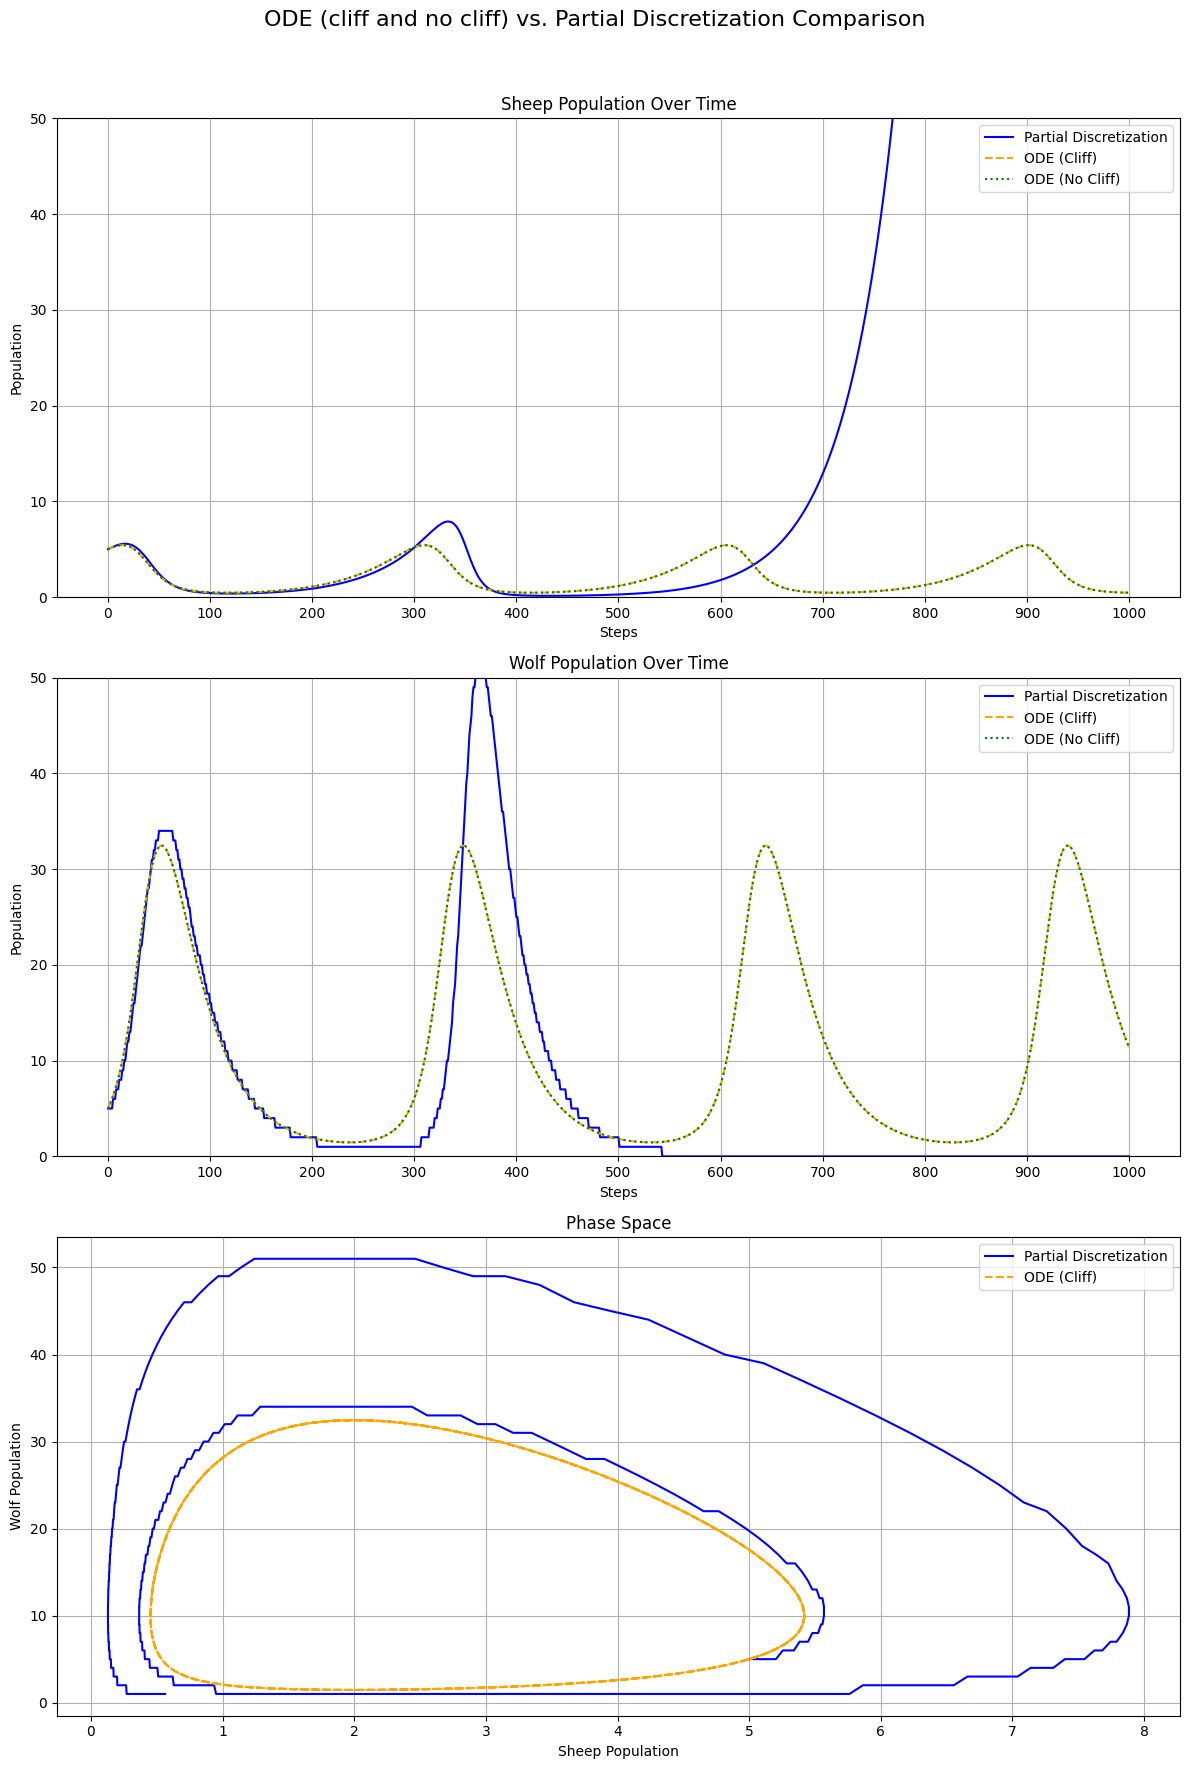

({'s': {'mae': 43.767440965689,
   'rmse': np.float64(88.99387636609377),
   'r2': -2817.60711516821},
  'w': {'mae': 7.458105594405595,
   'rmse': np.float64(11.901107695848392),
   'r2': -0.31698282473510697}},
           t       s        w
 0      0.00  5.0000   5.0000
 1      0.02  5.0491   5.2321
 2      0.04  5.0962   5.4789
 3      0.06  5.1412   5.7413
 4      0.08  5.1837   6.0202
 ...     ...     ...      ...
 996   19.92  0.4632  12.5199
 997   19.94  0.4610  12.2344
 998   19.96  0.4591  11.9550
 999   19.98  0.4574  11.6817
 1000  20.00  0.4560  11.4144
 
 [1001 rows x 3 columns],
           t       s        w
 0      0.00  5.0000   5.0000
 1      0.02  5.0491   5.2321
 2      0.04  5.0962   5.4789
 3      0.06  5.1412   5.7413
 4      0.08  5.1837   6.0202
 ...     ...     ...      ...
 996   19.92  0.4632  12.5199
 997   19.94  0.4610  12.2344
 998   19.96  0.4591  11.9550
 999   19.98  0.4574  11.6817
 1000  20.00  0.4560  11.4144
 
 [1001 rows x 3 columns],
           

In [2]:
model_params = {
        "alpha": 1.0,
        "beta": 0.1,
        "gamma": 1.5,
        "delta": 0.75,
        "s_start": 5,
        "w_start": 5,
        "dt": 0.02,
        "steps": 1000,
        "sheep_max": 210,
        "eps": 0.0
    }

test_prop_partial_discretization_matches_ode(model_params)


Wolves went extinct at step 915
{'steps': 1000, 'sheep_history': [5, 4.91, 4.82162, 4.73483084, 4.64960388488, 4.56591101495216, 4.483724616683022, 4.403017573582727, 4.323763257258238, 4.24593551862759, 4.169508679292293, 4.0944575230650315, 4.020757287649861, 3.9483836564721635, 3.8773127506556646, 3.8075211211438624, 3.738985740963273, 3.671683997625934, 3.6055936856686674, 3.5406929993266316, 3.476960525338752, 3.4143752358826545, 3.3529164816367665, 3.2925639849673045, 3.233297833237893, 3.175098472239611, 3.1179466997392984, 3.061823659143991, 3.0067108332793993, 2.9525900382803703, 2.8994434175913235, 2.8472534360746797, 2.7960028742253353, 2.745674822489279, 2.6962526756844722, 2.6477201275221516, 2.600061165226753, 2.5532600642526715, 2.5073013830961233, 2.462169958200393, 2.417850898952786, 2.3743295827716357, 2.331591650281746, 2.289623000576675, 2.248409786566295, 2.2079384104081017, 2.168195519020756, 2.1291679996783826, 2.0908429756841715, 2.0532078021218565, 2.0162500616

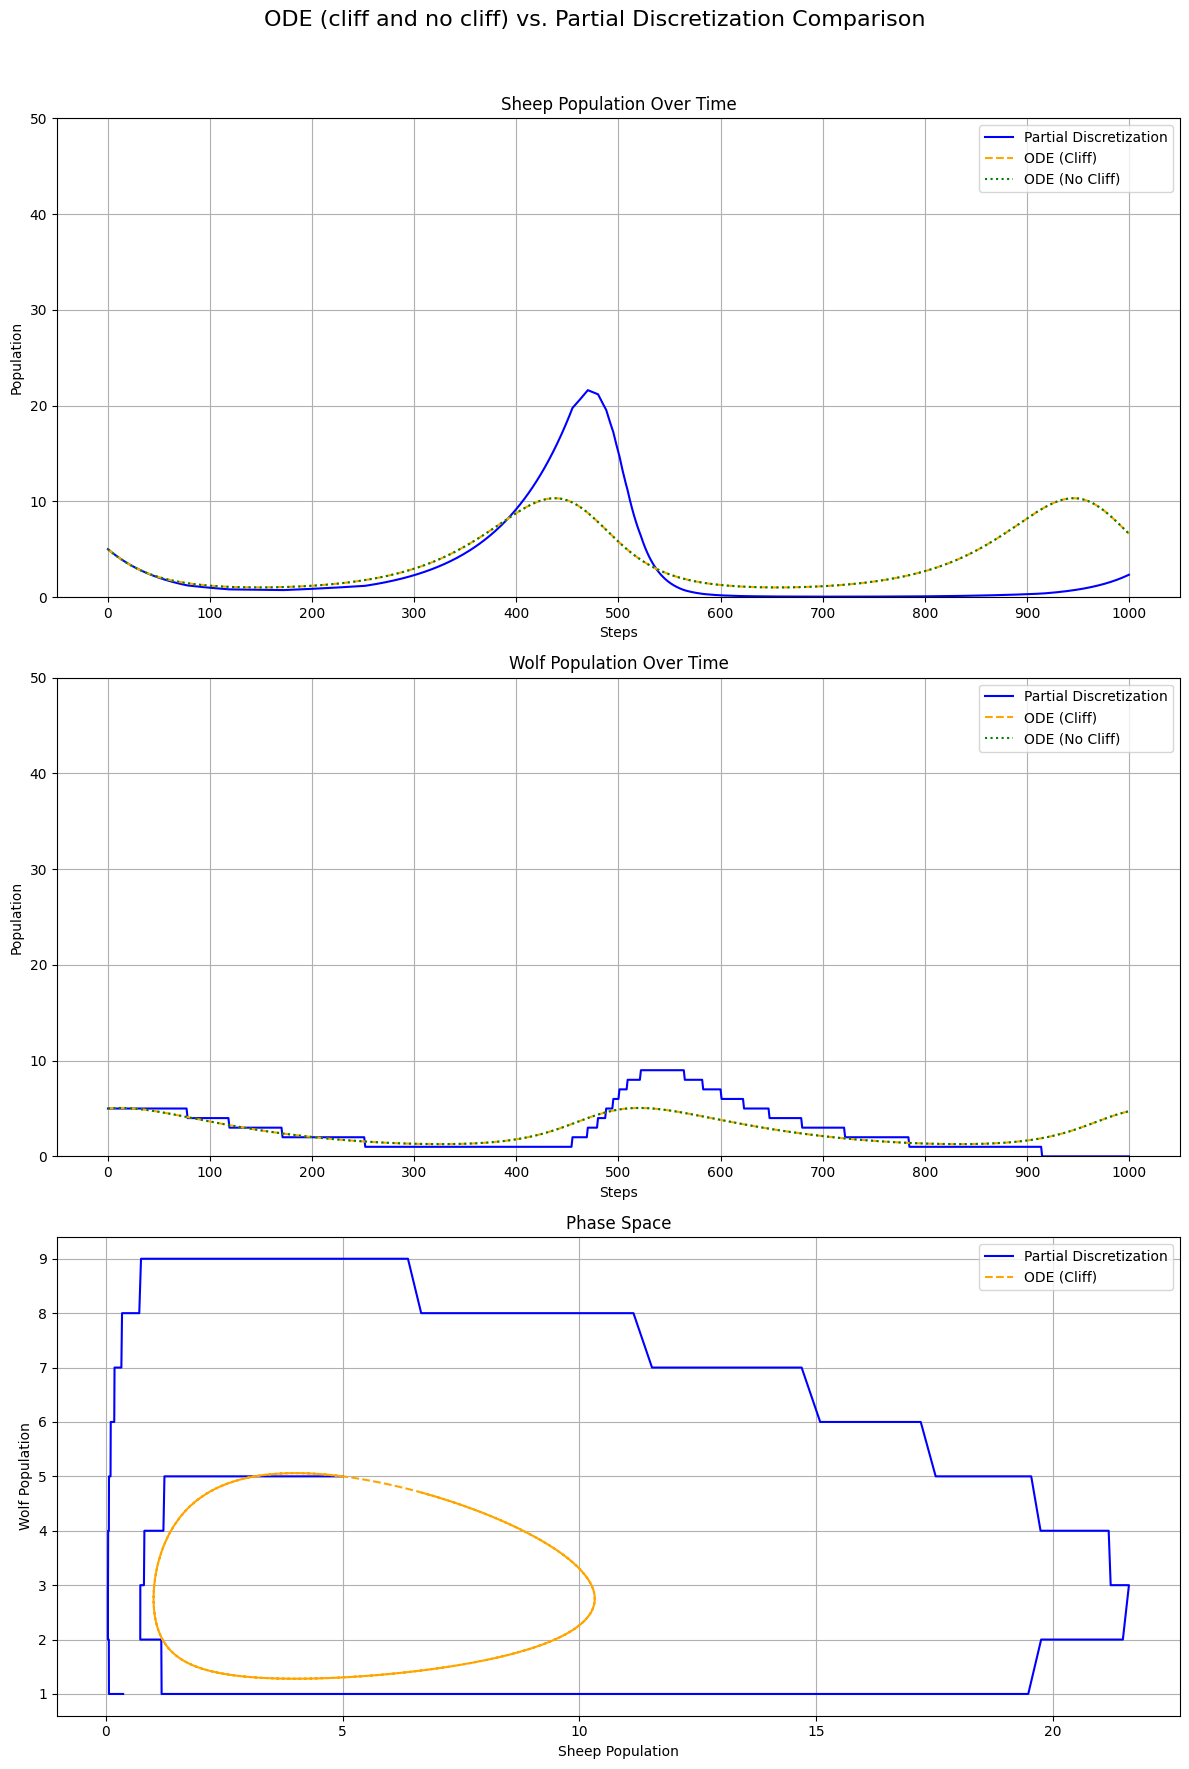

({'s': {'mae': 2.6816276944351416,
   'rmse': np.float64(4.326171599355905),
   'r2': -0.8950304685691022},
  'w': {'mae': 1.1449035964035965,
   'rmse': np.float64(1.6887319474208335),
   'r2': -0.7437350414751753}},
           t       s       w
 0      0.00  5.0000  5.0000
 1      0.02  4.9106  5.0096
 2      0.04  4.8225  5.0182
 3      0.06  4.7356  5.0261
 4      0.08  4.6500  5.0330
 ...     ...     ...     ...
 996   19.92  7.0337  4.6088
 997   19.94  6.9291  4.6364
 998   19.96  6.8246  4.6631
 999   19.98  6.7202  4.6891
 1000  20.00  6.6161  4.7142
 
 [1001 rows x 3 columns],
           t       s       w
 0      0.00  5.0000  5.0000
 1      0.02  4.9106  5.0096
 2      0.04  4.8225  5.0182
 3      0.06  4.7356  5.0261
 4      0.08  4.6500  5.0330
 ...     ...     ...     ...
 996   19.92  7.0337  4.6088
 997   19.94  6.9291  4.6364
 998   19.96  6.8246  4.6631
 999   19.98  6.7202  4.6891
 1000  20.00  6.6161  4.7142
 
 [1001 rows x 3 columns],
           t         s  w
 0  

In [3]:
model_params["alpha"] = 1.1
model_params["beta"] = 0.4
model_params["gamma"] = 0.4
model_params["delta"] = 0.1

test_prop_partial_discretization_matches_ode(model_params)

Wolves went extinct at step 2789
{'steps': 5000, 'sheep_history': [5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.98, 4.9600800000000005, 4.94023968, 4.92047872128, 4.90079680639488, 4.8811936191693, 4.861668844692623, 4.842222169313853, 4.822853280636598, 4.803561867514051, 4.784347620043995, 4.765210229563819, 4.746149388645564, 4.727164791090981, 4.708256131926618, 4.689423107398911, 4.670665414969315, 4.651982753309438, 4.633374822296201, 4.614841323007016, 4.596381957714988, 4.577996429884128, 4.559684444164591, 4.5414457063879325, 4.523279923562381, 4.505186803868131, 4.487166056652659, 4.4692173924260485, 4.451340522856344, 4.433535160764919, 4.415801020121859, 4.3981378160413716, 4.380545264777206, 4.363023083718097, 4.345570991383225, 4.3281887074176915, 4.31087595258802, 

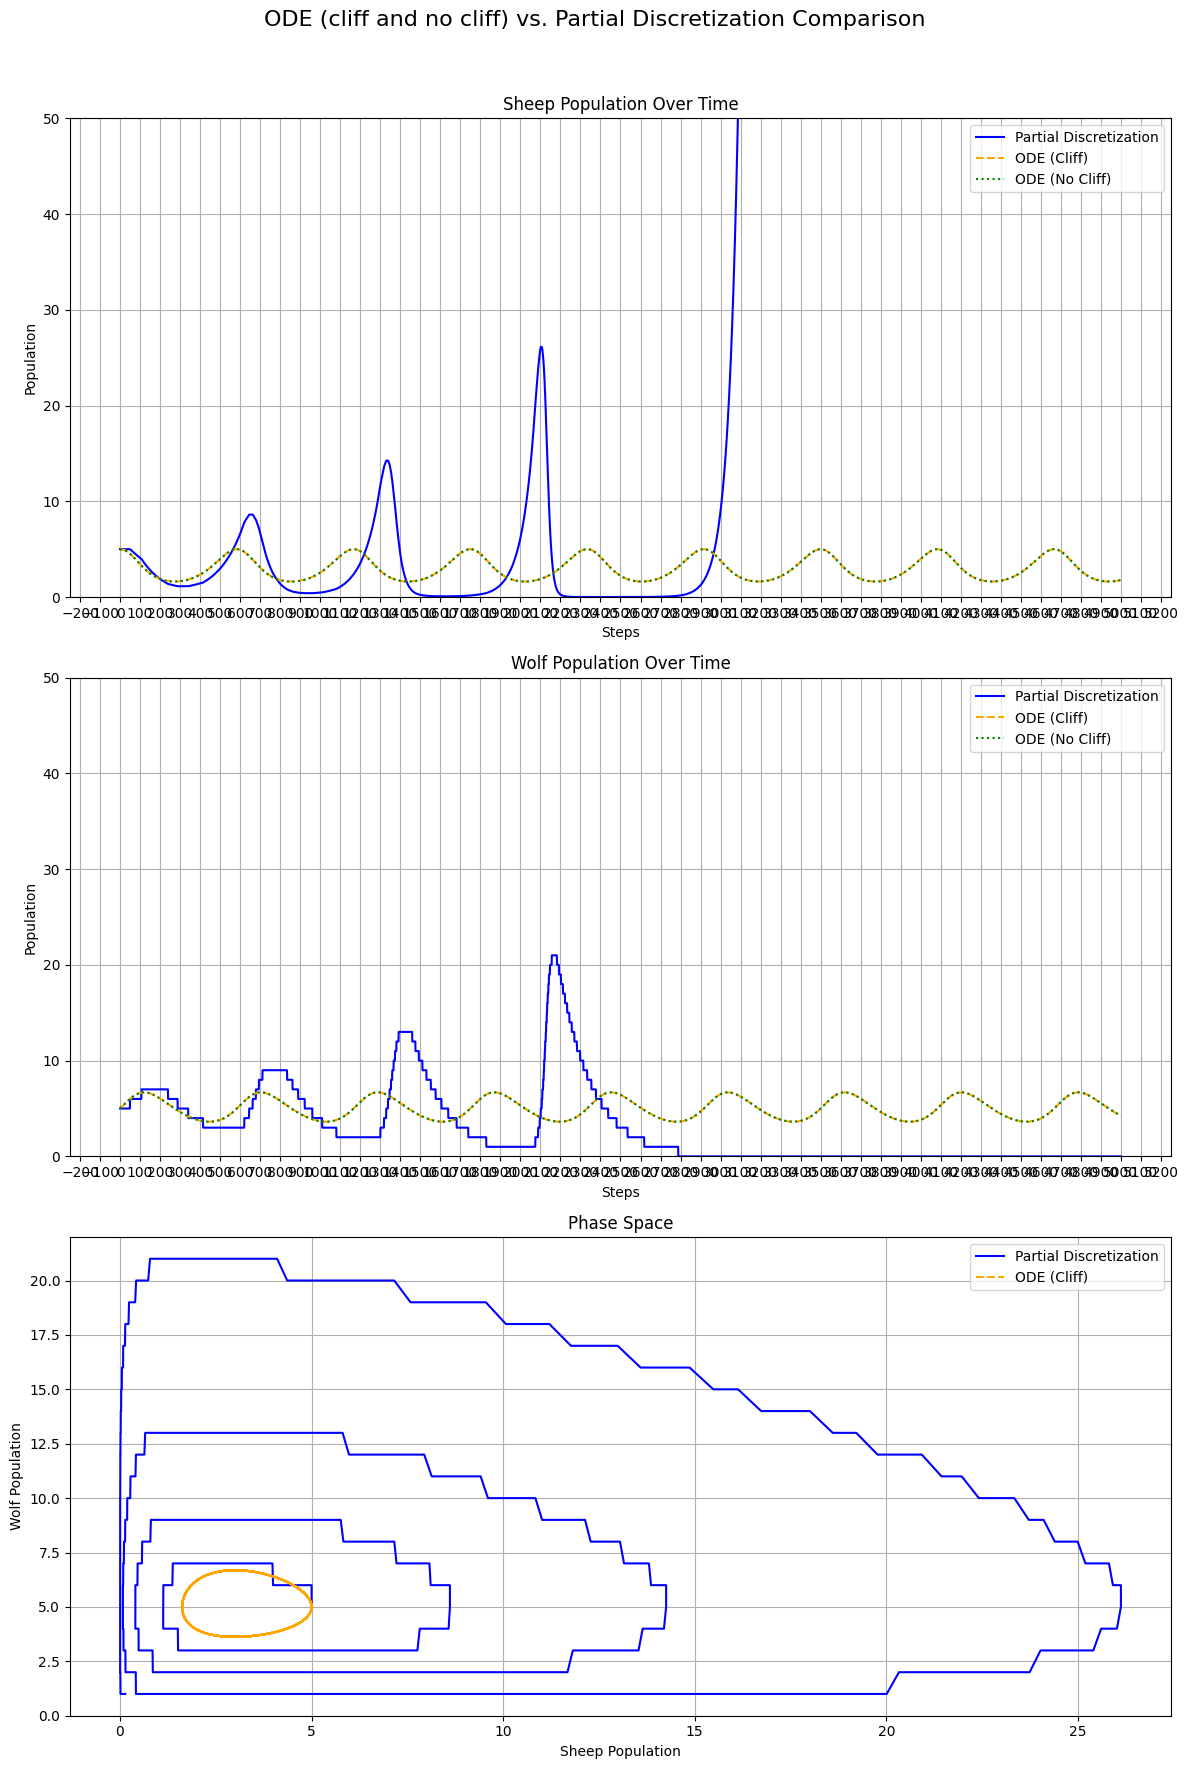

({'s': {'mae': 80.01767474999686,
   'rmse': np.float64(126.55595577744911),
   'r2': -11463.283748072323},
  'w': {'mae': 4.00476798640272,
   'rmse': np.float64(4.79612053845586),
   'r2': -18.92048398782929}},
            t       s       w
 0       0.00  5.0000  5.0000
 1       0.02  4.9998  5.0200
 2       0.04  4.9992  5.0402
 3       0.06  4.9982  5.0603
 4       0.08  4.9968  5.0806
 ...      ...     ...     ...
 4996   99.92  1.7618  4.2980
 4997   99.94  1.7668  4.2874
 4998   99.96  1.7718  4.2769
 4999   99.98  1.7770  4.2664
 5000  100.00  1.7823  4.2560
 
 [5001 rows x 3 columns],
            t       s       w
 0       0.00  5.0000  5.0000
 1       0.02  4.9998  5.0200
 2       0.04  4.9992  5.0402
 3       0.06  4.9982  5.0603
 4       0.08  4.9968  5.0806
 ...      ...     ...     ...
 4996   99.92  1.7618  4.2980
 4997   99.94  1.7668  4.2874
 4998   99.96  1.7718  4.2769
 4999   99.98  1.7770  4.2664
 5000  100.00  1.7823  4.2560
 
 [5001 rows x 3 columns],
           

In [4]:
model_params["alpha"] = 1.0
model_params["beta"] = 0.2
model_params["gamma"] = 0.3
model_params["delta"] = 0.1

model_params["steps"] = 5000

test_prop_partial_discretization_matches_ode(model_params)

### Notes

[^1] The Wikipedia page uses the word, "density," to describe the function of the varibles x and y. We think this is both incorrect and specifically a departure from the works of Lotka and Volterra. We have removed the word from our description.